### Generate synthetic data points

Data points are sampled from three normal distributions.

In [2]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

In [3]:
matplotlib inline

In [4]:
mu1, mu2, mu3 = [15,20], [24,25], [38,40]
cov = [[10, 0], [0, 10]]  
n_samples = 5000

In [5]:
data1 = rand.multivariate_normal(mu1, cov, n_samples)
data2 = rand.multivariate_normal(mu2, cov, n_samples)
data3 = rand.multivariate_normal(mu3, cov, n_samples)
data = np.vstack((data1, data2, data3))

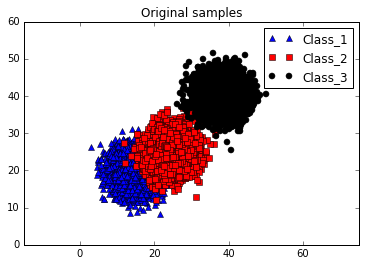

In [19]:
plt.axis('equal')
plt.plot(data1[:,0], data1[:,1], '^b', label='Class_1')
plt.plot(data2[:,0], data2[:,1], 'sr', label='Class_2')
plt.plot(data3[:,0], data3[:,1], 'ok', label='Class_3')
plt.title('Original samples')
plt.legend(loc='best')

### Compute mean values 

In [7]:
mu1 = np.mean(data1, 0)
mu2 = np.mean(data2, 0)
mu3 = np.mean(data3, 0)
mu  = np.mean(data, 0)

### Compute the between-class scatter matrix $S_b$ 

$S_b = \sum_{i}^{C} n_i (\mu^{i} - \mu)(\mu^{i} - \mu)^T$

In [8]:
s1 = np.outer(mu1-mu, mu1-mu)*data1.shape[0] 
s2 = np.outer(mu2-mu, mu2-mu)*data2.shape[0] 
s3 = np.outer(mu3-mu, mu3-mu)*data3.shape[0] 
S_b = s1 + s2 + s3

### Compute the within-class scatter matrix $S_w$ 


$S_w = \sum_{i=1}^{C} \sum_{j=1}^{n_i} (x^{i}_j - \mu_i)(x^{i}_j - \mu_i)^T$ 

In [9]:
def compute_within_scatter_matrix(data, mu):
    """ 
    Compute the within-class scatter matrix for a given class
    :param data: a numpy matrix of (n_samples, n_sample_dimensions)
    :param mu:  a list of n_sample_dimensions 
    """
    matrix = np.zeros((data.shape[1], data.shape[1]))
    spread = data - mu
    for s in range(spread.shape[0]):
        matrix += np.outer(spread[s,:], spread[s,:])
    return matrix 

In [10]:
s1 = compute_within_scatter_matrix(data1, mu1)
s2 = compute_within_scatter_matrix(data2, mu2)
s3 = compute_within_scatter_matrix(data3, mu3)
S_w = s1 + s2 + s3

### Solve the generalized eigenvalue problem for the matrix $S^{−1}_{w}S_{b}$


In [11]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

In [12]:
for eig_idx, eig_val in enumerate(eig_vals): 
    print('Eigvector #{}: {} (Eigvalue:{:.3f})'.format(eig_idx, eig_vecs[:, eig_idx], eig_val))

Eigvector #0: [ 0.74758134  0.66417027] (Eigvalue:16.076)
Eigvector #1: [-0.6710707   0.74139336] (Eigvalue:0.111)


### Double-check the computed eigen-vectors and eigen-values 

In [13]:
S = np.linalg.inv(S_w).dot(S_b)
for eig_idx, eig_val in enumerate(eig_vals):  
    eig_vec = eig_vecs[:, eig_idx]
    np.testing.assert_array_almost_equal(S.dot(eig_vec), eig_val*eig_vec, decimal=6, err_msg='', verbose=True)

### Sort the eigenvectors by decreasing eigenvalues

In [14]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted( eig_pairs, key=lambda x:x[0], reverse=True)
eigv_sum = sum(eig_vals)
for eig_val, eig_vec in eig_pairs:
    print('Eigvector: {} (Eigvalue:\t{:.3f},\t{:.2%} variance explained)'.format(eig_vec, eig_val, (eig_val/eigv_sum)))

Eigvector: [ 0.74758134  0.66417027] (Eigvalue:	16.076,	99.32% variance explained)
Eigvector: [-0.6710707   0.74139336] (Eigvalue:	0.111,	0.68% variance explained)


If we take a look at the eigenvalues, we can already see that the second eigenvalue are much smaller than the first one. 
Since Rank(AB) $\leq$ Rank(A), and Rank(AB) $\leq$ Rank(B), we have Rank($S_w^{-1}S_b$) $\leq$ Rank($S_b$). Due to that $S_b$ is the sum of $C$ matrices with rank 1 or less, Rank($S_b$) can be $C$-1 at most, where $C$ is the number of classes. This means that FDA can find at most $C$-1 meaningful features. The remining features discovered by FDA are arbitrary. 

### Choose m eigenvectors with the largest eigenvalues

After sorting the eigenpairs by decreasing eigenvalues, we can then construct our $d \times m$-dimensional transformation matrix $W$.
Here we choose the top most informative eigven-pair, as its eigenvalue explains 99.41% of the variance. As a result, the original d-dimensional (d=2) data points will be projected to a m-dimensional features space (m=1). 


In [15]:
W = eig_pairs[0][1]
print('Matrix W:\n', W.real)

('Matrix W:\n', array([ 0.74758134,  0.66417027]))


### Transforming the samples onto the new space

As the last step, we use the 1 $\times$ 2 dimensional matrix $W$ to transform our samples onto the embedding space via the equation $Y = W^TX$. FDA learns a linear transformation matrix $W \in R^{d \times m} (m \ll d)$， which maps each $d$-dimensional (d=2)
$x_i$  to a $m$-dimensional (m=1) $y_i$: $y_i = W^Tx_j $. 

In [16]:
X1_fda = W.dot(data1.T)
X2_fda = W.dot(data2.T)
X3_fda = W.dot(data3.T)

Now the transformed samples are scalar values. They are essentially the projection of the original data samples on the selected eigen vector, which corresponds to a straight line. To better visualize the projection, we visualize the transformed samples on the straight line under the original 2-dimensional space. 

In [17]:
slope = W[1]/W[0] 
Y1_fda = slope * X1_fda
Y2_fda = slope * X2_fda
Y3_fda = slope * X3_fda 

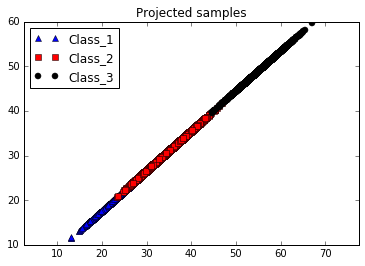

In [20]:
plt.axis('equal')
plt.plot(X1_fda, Y1_fda, '^b', label='Class_1')
plt.plot(X2_fda, Y2_fda, 'sr', label='Class_2')
plt.plot(X3_fda, Y3_fda, 'ok', label='Class_3')
plt.title('Projected samples')
plt.legend(loc='best')

From the plot we can see that the projected samples retain most of the 'intrinsic information' from the original data samples. Dots with the same color stay together, while those with different colours stay away.